# Logistic Regression - Price Only

For a ticker, given a sample period (e.g. 3-1-2009 to 12-31-2015), we train a logistic regression model to to predict it will become a 10 Bagger by 3-31-2019:  

10_bagger = f(price_t0, price_t1, ..., p_t_end)
 
where:  
* p_t0 - ticker's price on 3-1-2009
* p_t_end - ticker's price on the date in the sample period

We want to see how much a basic ML model like logistic regression can outperform the Baseline (Linear Interpolation).

In [2]:
import quandl  # Access to Sharadar Core US Equities Bundle
api_key = '7B87ndLPJbCDzpNHosH3'

import math
import platform
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
from sklearn import linear_model  # package for logistic regression (not using GPU)
import torch
import pandas as pd
from IPython.display import display
import time
import pickle

from utils import *

from datetime import date, datetime, time, timedelta


print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))

Python version:  3.6.6
Pytorch version: 1.1.0


## Import Labels

For each sample period (e.g. 3-1-2009 to 12-31-2018), we want to import a list of valid tickers. A valid ticker is defined as a ticker which is active for at least 180 days before the end of the sample period. 

For example, if the end of the sample period is 12-31-2018, a ticker has to be active since 7-4-2018. Any ticker that IPO after 7-4-2018 is not a valid ticker, since there is no enough price history to make an educated prediction.

In [2]:
labels = pd.read_csv("../datasets/sharader/labels_12-31-2018.csv")

y = labels.set_index('ticker')
y['firstpricedate']= pd.to_datetime(y['firstpricedate'])
y['lastpricedate']= pd.to_datetime(y['lastpricedate'])

y.head()

,appreciation,10bagger,table,permaticker,name,exchange,isdelisted,category,cusips,siccode,...,currency,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite
ticker,,,,,,,,,,,,,,,,,,,,,
A,6.339117,False,SEP,196290,Agilent Technologies Inc,NYSE,N,Domestic,00846U101,3826.0,...,USD,California; U.S.A,2020-01-14,2014-09-26,1999-11-18,2020-01-14,1997-06-30,2019-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.agilent.com
AA,1.224348,False,SEP,124392,Alcoa Corp,NYSE,N,Domestic,013872106,3350.0,...,USD,New York; U.S.A,2020-01-14,2016-11-01,2016-11-01,2020-01-14,2014-12-31,2019-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.alcoa.com
AAAGY,1.275556,False,SEP,120538,Altana Aktiengesellschaft,NYSE,Y,ADR,02143N103,2834.0,...,USD,Jordan,2018-10-16,2018-02-13,2002-05-22,2010-08-12,2000-12-31,2005-12-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN
AAAP,3.331837,False,SEP,155760,Advanced Accelerator Applications SA,NASDAQ,Y,ADR,00790T100,2834.0,...,USD,France,2018-06-28,2016-05-19,2015-11-11,2018-02-09,2012-12-31,2016-12-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN
AAC,0.099459,False,SEP,187592,AAC Holdings Inc,NYSE,Y,Domestic,000307108,8093.0,...,USD,Tennessee; U.S.A,2019-10-25,2015-09-11,2014-10-02,2019-10-25,2013-09-30,2019-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN


### A list of active tickers

In [3]:
tickers = list(y.index)
print(len(tickers))

valid_tickers = pd.Series(tickers, name = 'ticker')
valid_tickers.head()

9881


0        A
1       AA
2    AAAGY
3     AAAP
4      AAC
Name: ticker, dtype: object

In [2]:
prices = pd.read_csv("../datasets/sharader/inputs_notfilled_2018-12-31.csv")
X = prices .set_index('date')

X

,A,AA,AAAGY,AAAP,AAC,AACC,AACG,AACPF,AAGIY,AAI,...,ZUO,ZURVY,ZVO,ZVUE,ZXAIY,ZYME,ZYNE,ZYTO,ZYXI,ZZ
date,,,,,,,,,,,,,,,,,,,,,
2009-03-02,12.68,NaN,15.75,NaN,NaN,3.29,5.180,NaN,NaN,2.54,...,NaN,12.750,NaN,0.01,NaN,NaN,NaN,0.011,1.21,0.84
2009-03-03,12.68,NaN,15.75,NaN,NaN,3.30,5.320,NaN,NaN,2.46,...,NaN,12.850,NaN,0.01,NaN,NaN,NaN,0.011,1.22,0.76
2009-03-04,13.31,NaN,16.35,NaN,NaN,3.33,5.080,NaN,NaN,2.78,...,NaN,13.740,NaN,0.01,NaN,NaN,NaN,0.011,1.22,0.76
2009-03-05,12.54,NaN,15.59,NaN,NaN,3.30,5.080,NaN,NaN,2.56,...,NaN,11.910,NaN,0.01,NaN,NaN,NaN,0.011,1.17,0.58
2009-03-06,12.65,NaN,15.97,NaN,NaN,3.40,5.250,NaN,NaN,2.89,...,NaN,11.300,NaN,0.01,NaN,NaN,NaN,0.011,1.20,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,62.67,25.15,NaN,NaN,1.52,NaN,0.970,NaN,32.335,NaN,...,16.36,28.680,6.73,NaN,0.67,11.08,2.94,NaN,2.69,NaN
2018-12-26,65.54,27.14,NaN,NaN,1.67,NaN,0.998,NaN,32.700,NaN,...,17.81,29.050,6.78,NaN,0.67,11.99,2.92,NaN,2.63,NaN
2018-12-27,66.48,27.16,NaN,NaN,1.49,NaN,0.980,NaN,32.330,NaN,...,17.90,28.769,6.83,NaN,0.62,11.70,2.95,NaN,2.63,NaN


### Backfill and Forward Fill X_t

The logistic regression model expects no NaN values. We fill in the NaN values in the following way:

1. If there are NaN values before the first valid price, the ticker has an IPO in the sample period. We thus set these NaN values to zero.
2. If there are NaN values after the last valid price, the ticker has been delisted in the sample period. We thus set these NaN values to the last valid price.


In [5]:
X_filled = X.fillna(axis=0, method='ffill')  # forward fill along date axis with last valid price
X_filled = X_filled.fillna(0)  # fill all other NaN with zero - remaining NaN before the first valid price
X_train = X_filled.transpose()

print (X_train.shape)
display(X_train)

(9881, 2477)


date,2009-03-02,2009-03-03,2009-03-04,2009-03-05,2009-03-06,2009-03-09,2009-03-10,2009-03-11,2009-03-12,2009-03-13,...,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-24,2018-12-26,2018-12-27,2018-12-28,2018-12-31
A,12.680,12.680,13.310,12.540,12.650,12.440,13.430,13.530,13.810,13.990,...,67.85,67.99,66.83,65.19,63.29,62.67,65.54,66.48,65.96,67.46
AA,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,28.11,28.24,27.61,27.33,26.39,25.15,27.14,27.16,26.60,26.58
AAAGY,15.750,15.750,16.350,15.590,15.970,15.960,16.200,16.150,16.500,16.360,...,20.09,20.09,20.09,20.09,20.09,20.09,20.09,20.09,20.09,20.09
AAAP,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,81.63,81.63,81.63,81.63,81.63,81.63,81.63,81.63,81.63,81.63
AAC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.97,1.96,1.78,1.63,1.56,1.52,1.67,1.49,1.41,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYME,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,12.77,12.80,11.70,11.32,10.95,11.08,11.99,11.70,13.65,14.68
ZYNE,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,4.10,3.73,3.58,3.21,2.89,2.94,2.92,2.95,2.92,2.97
ZYTO,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.012,0.012,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
ZYXI,1.210,1.220,1.220,1.170,1.200,1.100,1.000,1.000,1.010,1.050,...,3.04,2.96,3.07,2.89,2.81,2.69,2.63,2.63,2.65,2.94


In [6]:
y_train = y['10bagger']

print (y_train.shape)
print(sum(y_train))

(9881,)
531


## Failure to Converge

Convergence issues encountered when only nominal ticker price used.

In [32]:
C_values = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 1e1, 1e2, 1e3, 1e4]

for C in C_values:
    
    print("Regularization: {}".format(C))

    model = linear_model.LogisticRegression(C=C, class_weight='balanced', max_iter=10000)
    model.fit(X_train, y_train)

    predicts = model.predict(X_train)
    correct = predicts == y_train
    
    TP,FP,TN,FN = calc_metrics(predicts,y_train)

    print(TP,FP,TN,FN)

    precision, recall, accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

    print("Precision:{:.3f} Recall:{:.3f}".format(precision, recall))
    print("Accuracy:{:.3f} TPR:{:.3f} TNR:{:.3f} BER:{:.3f}".format(accuracy, TPR, TNR, BER))

Regularization: 0.0001


/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


487 2444 6906 44
Precision:0.166 Recall:0.917
Accuracy:0.748 TPR:0.917 TNR:0.739 BER:0.172
Regularization: 0.001


/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


486 2787 6563 45
Precision:0.148 Recall:0.915
Accuracy:0.713 TPR:0.915 TNR:0.702 BER:0.191
Regularization: 0.01


/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


502 2821 6529 29
Precision:0.151 Recall:0.945
Accuracy:0.712 TPR:0.945 TNR:0.698 BER:0.178
Regularization: 0.1


/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


509 3256 6094 22
Precision:0.135 Recall:0.959
Accuracy:0.668 TPR:0.959 TNR:0.652 BER:0.195
Regularization: 1.0


/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


494 2713 6637 37
Precision:0.154 Recall:0.930
Accuracy:0.722 TPR:0.930 TNR:0.710 BER:0.180
Regularization: 10.0


/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


497 2729 6621 34
Precision:0.154 Recall:0.936
Accuracy:0.720 TPR:0.936 TNR:0.708 BER:0.178
Regularization: 100.0


/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


485 2559 6791 46
Precision:0.159 Recall:0.913
Accuracy:0.736 TPR:0.913 TNR:0.726 BER:0.180
Regularization: 1000.0


/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


489 2680 6670 42
Precision:0.154 Recall:0.921
Accuracy:0.725 TPR:0.921 TNR:0.713 BER:0.183
Regularization: 10000.0
506 3241 6109 25
Precision:0.135 Recall:0.953
Accuracy:0.669 TPR:0.953 TNR:0.653 BER:0.197


/home/lukeai/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Normalize Ticker Price

The model converges when ticker prices are normalized (first valid price = 1.0).

In [7]:
first_valid_prices = X.apply(first_valid_idx, axis=0)

first_valid_prices

A        12.680
AA       23.000
AAAGY    15.750
AAAP     24.500
AAC      18.500
          ...  
ZYME     13.000
ZYNE     16.250
ZYTO      0.011
ZYXI      1.210
ZZ        0.840
Length: 9881, dtype: float64

In [8]:
X_filled = X.fillna(axis=0, method='ffill')  # forward fill along date axis with last valid price
X_filled = X_filled.fillna(0)  # fill all other NaN with zero - remaining NaN before the first valid price

# Transpose Dataframe in rows of tickers, and normalize price
X_all = X_filled.transpose().div(first_valid_prices, axis=0)

X_all

date,2009-03-02,2009-03-03,2009-03-04,2009-03-05,2009-03-06,2009-03-09,2009-03-10,2009-03-11,2009-03-12,2009-03-13,...,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-24,2018-12-26,2018-12-27,2018-12-28,2018-12-31
A,1.0,1.000000,1.049685,0.988959,0.997634,0.981073,1.059148,1.067035,1.089117,1.103312,...,5.350946,5.361987,5.270505,5.141167,4.991325,4.942429,5.168770,5.242902,5.201893,5.320189
AA,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.222174,1.227826,1.200435,1.188261,1.147391,1.093478,1.180000,1.180870,1.156522,1.155652
AAAGY,1.0,1.000000,1.038095,0.989841,1.013968,1.013333,1.028571,1.025397,1.047619,1.038730,...,1.275556,1.275556,1.275556,1.275556,1.275556,1.275556,1.275556,1.275556,1.275556,1.275556
AAAP,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.331837,3.331837,3.331837,3.331837,3.331837,3.331837,3.331837,3.331837,3.331837,3.331837
AAC,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.106486,0.105946,0.096216,0.088108,0.084324,0.082162,0.090270,0.080541,0.076216,0.075676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYME,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.982308,0.984615,0.900000,0.870769,0.842308,0.852308,0.922308,0.900000,1.050000,1.129231
ZYNE,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.252308,0.229538,0.220308,0.197538,0.177846,0.180923,0.179692,0.181538,0.179692,0.182769
ZYTO,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.090909,1.090909,...,2.727273,2.727273,2.727273,2.727273,2.727273,2.727273,2.727273,2.727273,2.727273,2.727273
ZYXI,1.0,1.008264,1.008264,0.966942,0.991736,0.909091,0.826446,0.826446,0.834711,0.867769,...,2.512397,2.446281,2.537190,2.388430,2.322314,2.223140,2.173554,2.173554,2.190083,2.429752


In [9]:
y_all = y['10bagger']
y_all

ticker
A        False
AA       False
AAAGY    False
AAAP     False
AAC      False
         ...  
ZYME     False
ZYNE     False
ZYTO     False
ZYXI     False
ZZ       False
Name: 10bagger, Length: 9881, dtype: bool

In [10]:
data = X_all.merge(y_all, left_index=True, right_index=True)

data

,2009-03-02,2009-03-03,2009-03-04,2009-03-05,2009-03-06,2009-03-09,2009-03-10,2009-03-11,2009-03-12,2009-03-13,...,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-24,2018-12-26,2018-12-27,2018-12-28,2018-12-31,10bagger
A,1.0,1.000000,1.049685,0.988959,0.997634,0.981073,1.059148,1.067035,1.089117,1.103312,...,5.361987,5.270505,5.141167,4.991325,4.942429,5.168770,5.242902,5.201893,5.320189,False
AA,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.227826,1.200435,1.188261,1.147391,1.093478,1.180000,1.180870,1.156522,1.155652,False
AAAGY,1.0,1.000000,1.038095,0.989841,1.013968,1.013333,1.028571,1.025397,1.047619,1.038730,...,1.275556,1.275556,1.275556,1.275556,1.275556,1.275556,1.275556,1.275556,1.275556,False
AAAP,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.331837,3.331837,3.331837,3.331837,3.331837,3.331837,3.331837,3.331837,3.331837,False
AAC,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.105946,0.096216,0.088108,0.084324,0.082162,0.090270,0.080541,0.076216,0.075676,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYME,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.984615,0.900000,0.870769,0.842308,0.852308,0.922308,0.900000,1.050000,1.129231,False
ZYNE,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.229538,0.220308,0.197538,0.177846,0.180923,0.179692,0.181538,0.179692,0.182769,False
ZYTO,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.090909,1.090909,...,2.727273,2.727273,2.727273,2.727273,2.727273,2.727273,2.727273,2.727273,2.727273,False
ZYXI,1.0,1.008264,1.008264,0.966942,0.991736,0.909091,0.826446,0.826446,0.834711,0.867769,...,2.446281,2.537190,2.388430,2.322314,2.223140,2.173554,2.173554,2.190083,2.429752,False


In [11]:
# Shuffle the data
shuffled_data = data.sample(frac=1)
display(shuffled_data.head())

# Split 
split = 6000
train_x = shuffled_data.iloc[:split,:-1]
train_y = shuffled_data.iloc[:split, -1]
display(train_x)
display(train_y)

valid_x = shuffled_data.iloc[split+1:,:-1]
valid_y = shuffled_data.iloc[split+1:, -1]
display(valid_x)
display(valid_y)


,2009-03-02,2009-03-03,2009-03-04,2009-03-05,2009-03-06,2009-03-09,2009-03-10,2009-03-11,2009-03-12,2009-03-13,...,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-24,2018-12-26,2018-12-27,2018-12-28,2018-12-31,10bagger
QD,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.184373,0.174092,0.172378,0.158328,0.160041,0.160384,0.157642,0.150103,0.147019,False
ECTX1,1.0,1.100000,1.350000,1.450000,1.050000,1.000000,1.000000,1.000000,1.050000,0.950000,...,3.150000,3.150000,3.150000,3.150000,3.150000,3.150000,3.150000,3.150000,3.150000,False
TCBI,1.0,0.953159,0.906318,0.784314,0.755991,0.735294,0.809368,0.812636,0.943355,0.936819,...,5.545752,5.422658,5.440087,5.427015,5.282135,5.571895,5.520697,5.555556,5.565359,False
SNV,1.0,0.954397,0.931596,0.804560,0.863192,0.827362,0.993485,0.996743,1.104235,1.016287,...,1.457887,1.429967,1.455095,1.436947,1.407631,1.480223,1.461610,1.487203,1.488599,False
MH-PA,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.312016,0.312016,0.291473,0.271318,0.266279,0.275194,0.259690,0.339535,0.358527,False


,2009-03-02,2009-03-03,2009-03-04,2009-03-05,2009-03-06,2009-03-09,2009-03-10,2009-03-11,2009-03-12,2009-03-13,...,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-24,2018-12-26,2018-12-27,2018-12-28,2018-12-31
QD,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.189171,0.184373,0.174092,0.172378,0.158328,0.160041,0.160384,0.157642,0.150103,0.147019
ECTX1,1.0,1.100000,1.350000,1.450000,1.050000,1.000000,1.000000,1.000000,1.050000,0.950000,...,3.150000,3.150000,3.150000,3.150000,3.150000,3.150000,3.150000,3.150000,3.150000,3.150000
TCBI,1.0,0.953159,0.906318,0.784314,0.755991,0.735294,0.809368,0.812636,0.943355,0.936819,...,5.697168,5.545752,5.422658,5.440087,5.427015,5.282135,5.571895,5.520697,5.555556,5.565359
SNV,1.0,0.954397,0.931596,0.804560,0.863192,0.827362,0.993485,0.996743,1.104235,1.016287,...,1.482550,1.457887,1.429967,1.455095,1.436947,1.407631,1.480223,1.461610,1.487203,1.488599
MH-PA,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.320543,0.312016,0.312016,0.291473,0.271318,0.266279,0.275194,0.259690,0.339535,0.358527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REVU,1.0,1.002222,1.017778,0.957778,0.962222,0.955556,1.046667,0.960000,1.115556,0.995556,...,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222
IPDN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.029009,0.026076,0.026076,0.025750,0.022164,0.020372,0.020372,0.017438,0.014733,0.016297
PSB-PT,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.068574,1.068574,1.068574,1.068574,1.068574,1.068574,1.068574,1.068574,1.068574,1.068574
TTEC,1.0,1.001170,1.050292,0.992982,1.012865,1.008187,1.142690,1.128655,1.155556,1.153216,...,3.057310,3.086550,3.076023,3.060819,2.938012,2.884211,3.121637,3.128655,3.222222,3.341520


QD        False
ECTX1     False
TCBI      False
SNV       False
MH-PA     False
          ...  
REVU      False
IPDN      False
PSB-PT    False
TTEC      False
CVG       False
Name: 10bagger, Length: 6000, dtype: bool

,2009-03-02,2009-03-03,2009-03-04,2009-03-05,2009-03-06,2009-03-09,2009-03-10,2009-03-11,2009-03-12,2009-03-13,...,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-24,2018-12-26,2018-12-27,2018-12-28,2018-12-31
ALTX,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.824176,0.824176,0.824176,0.824176,0.824176,0.824176,0.824176,0.824176,0.824176,0.824176
TR,1.0,0.962820,1.000474,0.953214,0.968869,0.966378,0.982804,0.989267,1.032436,1.063271,...,2.003676,2.025024,2.050522,2.035697,2.017908,1.958610,1.978771,1.984701,1.969877,1.980550
CORVF,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.775926,1.722222,1.694444,1.855556,1.842593,1.870370,1.898148,1.825926,1.822222,1.855556
HBANP,1.0,0.911216,0.952941,0.784314,0.831333,0.815686,0.976471,1.019569,1.053686,1.078431,...,5.160784,5.160784,5.160784,5.160784,5.160784,5.160784,5.160784,5.160784,5.160784,5.160784
CRY,1.0,0.933481,0.986696,0.895787,0.909091,0.891353,0.902439,0.886918,1.008869,1.070953,...,6.157428,6.144124,6.022173,5.858093,5.782705,5.711752,6.077605,6.110865,6.221729,6.292683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LZ,1.0,0.960372,1.026284,1.025071,1.058229,1.039628,1.105540,1.146381,1.186009,1.191266,...,5.457744,5.457744,5.457744,5.457744,5.457744,5.457744,5.457744,5.457744,5.457744,5.457744
SCE-PF,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.087841,1.087841,1.087841,1.087841,1.087841,1.087841,1.087841,1.087841,1.087841,1.087841
BCRH,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.366138,0.354497,0.319577,0.315344,0.300529,0.298942,0.283598,0.316402,0.300000,0.291005
PBR.A,1.0,1.006839,1.087445,1.063508,1.056180,1.054714,1.131412,1.131900,1.175867,1.180264,...,0.565706,0.549585,0.553493,0.547142,0.539326,0.530532,0.565217,0.564729,0.566194,0.566194


ALTX      False
TR        False
CORVF     False
HBANP     False
CRY       False
          ...  
LZ        False
SCE-PF    False
BCRH      False
PBR.A     False
PINC      False
Name: 10bagger, Length: 3880, dtype: bool

In [12]:
C_values = [1e-5, 1e-3, 1e-2, 1e-1, 5e-1, 1.0, 5, 10, 1e2]

for C in C_values:
    
    print("Regularization: {}".format(C))

    model = linear_model.LogisticRegression(C=C, class_weight='balanced', max_iter=10000)
    model.fit(train_x, train_y)

    predicts = model.predict(valid_x)
   
    correct = predicts == valid_y
    
    # This code section is to generate Precision@N stats
    # Sort labels and scores in descending order
    scores = model.decision_function(valid_x)
    scores_labels = list(zip(scores, valid_y))
    scores_labels.sort(reverse = True)
    sortedlabels = [x[1] for x in scores_labels] # generate sorted labels
    
    TP,FP,TN,FN = calc_metrics(predicts,valid_y)

    print(TP,FP,TN,FN)

    precision, recall, accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

    print("Precision:{:.3f} Recall:{:.3f}".format(precision, recall))
    
    # output Precision@N stats
    print("Precision@100: {}".format(sum(sortedlabels[:100]) / 100))
    print("Precision@90: {}".format(sum(sortedlabels[:90]) / 90))
    print("Precision@80: {}".format(sum(sortedlabels[:80]) / 80))
    print("Precision@70: {}".format(sum(sortedlabels[:70]) / 70))
    print("Precision@60: {}".format(sum(sortedlabels[:60]) / 60))
    print("Precision@50: {}".format(sum(sortedlabels[:50]) / 50))
    print("Precision@40: {}".format(sum(sortedlabels[:40]) / 40))
    print("Precision@30: {}".format(sum(sortedlabels[:30]) / 30))
    print("Precision@20: {}".format(sum(sortedlabels[:20]) / 20))
    print("Precision@10: {}".format(sum(sortedlabels[:10]) / 10))
        
    print("Accuracy:{:.3f} TPR:{:.3f} TNR:{:.3f} BER:{:.3f}".format(accuracy, TPR, TNR, BER))
    print('\n')
    
    

Regularization: 1e-05
211 131 3536 2
Precision:0.617 Recall:0.991
Precision@100: 0.99
Precision@90: 0.9888888888888889
Precision@80: 0.9875
Precision@70: 0.9857142857142858
Precision@60: 0.9833333333333333
Precision@50: 1.0
Precision@40: 1.0
Precision@30: 1.0
Precision@20: 1.0
Precision@10: 1.0
Accuracy:0.966 TPR:0.991 TNR:0.964 BER:0.023


Regularization: 0.001
212 80 3587 1
Precision:0.726 Recall:0.995
Precision@100: 0.99
Precision@90: 0.9888888888888889
Precision@80: 0.9875
Precision@70: 1.0
Precision@60: 1.0
Precision@50: 1.0
Precision@40: 1.0
Precision@30: 1.0
Precision@20: 1.0
Precision@10: 1.0
Accuracy:0.979 TPR:0.995 TNR:0.978 BER:0.013


Regularization: 0.01
205 57 3610 8
Precision:0.782 Recall:0.962
Precision@100: 0.98
Precision@90: 0.9888888888888889
Precision@80: 0.9875
Precision@70: 1.0
Precision@60: 1.0
Precision@50: 1.0
Precision@40: 1.0
Precision@30: 1.0
Precision@20: 1.0
Precision@10: 1.0
Accuracy:0.983 TPR:0.962 TNR:0.984 BER:0.027


Regularization: 0.1
203 46 3621 10

In [27]:
label_filenames = ['labels_12-31-2010.csv',
              'labels_12-31-2011.csv',
              'labels_12-31-2012.csv',
              'labels_12-31-2013.csv',
              'labels_12-31-2014.csv',
              'labels_12-31-2015.csv',
              'labels_12-31-2016.csv',
              'labels_12-31-2017.csv',
              'labels_12-31-2018.csv'
             ]

prices_filenames = ['inputs_notfilled_2010-12-31.csv',
            'inputs_notfilled_2011-12-31.csv',
            'inputs_notfilled_2012-12-31.csv',
            'inputs_notfilled_2013-12-31.csv',
            'inputs_notfilled_2014-12-31.csv',
            'inputs_notfilled_2015-12-31.csv',
            'inputs_notfilled_2016-12-31.csv',
            'inputs_notfilled_2017-12-31.csv',
            'inputs_notfilled_2018-12-31.csv'
              ]

top100s = {}

for label_filename, prices_filename in zip(label_filenames, prices_filenames):
    
    print(label_filename)
    top100s[label_filename]={}
    
    labels = pd.read_csv("../datasets/sharader/"+label_filename)
    y = labels.set_index('ticker')
    y_all = y['10bagger']
    
    
    prices = pd.read_csv("../datasets/sharader/"+prices_filename)
    X = prices.set_index('date')
    first_valid_prices = X.apply(first_valid_idx, axis=0)
    
    X_filled = X.fillna(axis=0, method='ffill')  # forward fill along date axis with last valid price
    X_filled = X_filled.fillna(0)  # fill all other NaN with zero - remaining NaN before the first valid price

    # Transpose Dataframe in rows of tickers, and normalize price
    X_all = X_filled.transpose().div(first_valid_prices, axis=0)
    
    data = X_all.merge(y_all, left_index=True, right_index=True)
    
    # Shuffle the data
    shuffled_data = data.sample(frac=1)

    # Split 
    split = int(len(shuffled_data.index)*0.7)
    train_x = shuffled_data.iloc[:split,:-1]
    train_y = shuffled_data.iloc[:split, -1]

    valid_x = shuffled_data.iloc[split+1:,:-1]
    valid_y = shuffled_data.iloc[split+1:, -1]
    
    valid_tickers = shuffled_data.iloc[split+1:, -1].index
    
    C_values = [1e-7, 1e-6, 1e-5, 1e-3, 1e-2, 1e-1, 5e-1, 1.0, 10
               ]

    for C in C_values:

        print("Regularization: {}".format(C))
        

        model = linear_model.LogisticRegression(C=C, class_weight='balanced', max_iter=10000)
        model.fit(train_x, train_y)

        predicts = model.predict(valid_x)
        correct = predicts == valid_y
        
        # This code section is to generate Precision@N stats
        # Sort labels and scores in descending order
        scores = model.decision_function(valid_x)
        scores_labels = list(zip(scores, valid_y, valid_tickers))
        scores_labels.sort(reverse = True)
        sortedlabels = [x[1] for x in scores_labels] # generate sorted labels
        
        top100s[label_filename][C] = [x[2] for x in scores_labels]  # save top 100 tickers

        TP,FP,TN,FN = calc_metrics(predicts,valid_y)

        print(TP,FP,TN,FN)

        precision, recall, accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

        print("Precision:{:.3f} Recall:{:.3f}".format(precision, recall))
        
        # output Precision@N stats
        print("Precision@100: {}".format(sum(sortedlabels[:100]) / 100))
        print("Precision@90: {}".format(sum(sortedlabels[:90]) / 90))
        print("Precision@80: {}".format(sum(sortedlabels[:80]) / 80))
        print("Precision@70: {}".format(sum(sortedlabels[:70]) / 70))
        print("Precision@60: {}".format(sum(sortedlabels[:60]) / 60))
        print("Precision@50: {}".format(sum(sortedlabels[:50]) / 50))
        print("Precision@40: {}".format(sum(sortedlabels[:40]) / 40))
        print("Precision@30: {}".format(sum(sortedlabels[:30]) / 30))
        print("Precision@20: {}".format(sum(sortedlabels[:20]) / 20))
        print("Precision@10: {}".format(sum(sortedlabels[:10]) / 10))
    
        print("Accuracy:{:.3f} TPR:{:.3f} TNR:{:.3f} BER:{:.3f}".format(accuracy, TPR, TNR, BER))
        print('\n')



labels_12-31-2010.csv
Regularization: 1e-07
70 151 1667 76
Precision:0.317 Recall:0.479
Precision@100: 0.43
Precision@90: 0.4444444444444444
Precision@80: 0.45
Precision@70: 0.45714285714285713
Precision@60: 0.45
Precision@50: 0.46
Precision@40: 0.475
Precision@30: 0.4666666666666667
Precision@20: 0.45
Precision@10: 0.6
Accuracy:0.884 TPR:0.479 TNR:0.917 BER:0.302


Regularization: 1e-06
79 205 1613 67
Precision:0.278 Recall:0.541
Precision@100: 0.44
Precision@90: 0.4444444444444444
Precision@80: 0.475
Precision@70: 0.4714285714285714
Precision@60: 0.45
Precision@50: 0.44
Precision@40: 0.5
Precision@30: 0.5
Precision@20: 0.5
Precision@10: 0.6
Accuracy:0.862 TPR:0.541 TNR:0.887 BER:0.286


Regularization: 1e-05
83 233 1585 63
Precision:0.263 Recall:0.568
Precision@100: 0.46
Precision@90: 0.4777777777777778
Precision@80: 0.475
Precision@70: 0.4857142857142857
Precision@60: 0.5
Precision@50: 0.5
Precision@40: 0.525
Precision@30: 0.5
Precision@20: 0.55
Precision@10: 0.6
Accuracy:0.849 TPR:

83 190 1812 49
Precision:0.304 Recall:0.629
Precision@100: 0.48
Precision@90: 0.5111111111111111
Precision@80: 0.525
Precision@70: 0.5428571428571428
Precision@60: 0.5833333333333334
Precision@50: 0.58
Precision@40: 0.575
Precision@30: 0.6
Precision@20: 0.6
Precision@10: 0.6
Accuracy:0.888 TPR:0.629 TNR:0.905 BER:0.233


Regularization: 1.0
81 195 1807 51
Precision:0.293 Recall:0.614
Precision@100: 0.49
Precision@90: 0.5111111111111111
Precision@80: 0.525
Precision@70: 0.5285714285714286
Precision@60: 0.55
Precision@50: 0.58
Precision@40: 0.6
Precision@30: 0.6
Precision@20: 0.6
Precision@10: 0.7
Accuracy:0.885 TPR:0.614 TNR:0.903 BER:0.242


Regularization: 10
66 196 1806 66
Precision:0.252 Recall:0.500
Precision@100: 0.43
Precision@90: 0.4444444444444444
Precision@80: 0.475
Precision@70: 0.4857142857142857
Precision@60: 0.48333333333333334
Precision@50: 0.52
Precision@40: 0.55
Precision@30: 0.5333333333333333
Precision@20: 0.55
Precision@10: 0.5
Accuracy:0.877 TPR:0.500 TNR:0.902 BER:

145 166 2282 17
Precision:0.466 Recall:0.895
Precision@100: 0.79
Precision@90: 0.8111111111111111
Precision@80: 0.8625
Precision@70: 0.9
Precision@60: 0.9333333333333333
Precision@50: 0.94
Precision@40: 0.975
Precision@30: 1.0
Precision@20: 1.0
Precision@10: 1.0
Accuracy:0.930 TPR:0.895 TNR:0.932 BER:0.086


Regularization: 0.01
141 158 2290 21
Precision:0.472 Recall:0.870
Precision@100: 0.77
Precision@90: 0.7777777777777778
Precision@80: 0.8375
Precision@70: 0.9
Precision@60: 0.9
Precision@50: 0.92
Precision@40: 0.925
Precision@30: 0.9333333333333333
Precision@20: 0.9
Precision@10: 1.0
Accuracy:0.931 TPR:0.870 TNR:0.935 BER:0.097


Regularization: 0.1
127 125 2323 35
Precision:0.504 Recall:0.784
Precision@100: 0.75
Precision@90: 0.7333333333333333
Precision@80: 0.7375
Precision@70: 0.7857142857142857
Precision@60: 0.8
Precision@50: 0.8
Precision@40: 0.875
Precision@30: 0.8666666666666667
Precision@20: 0.85
Precision@10: 0.8
Accuracy:0.939 TPR:0.784 TNR:0.949 BER:0.134


Regularization

Regularization: 1e-07
149 100 2702 13
Precision:0.598 Recall:0.920
Precision@100: 0.91
Precision@90: 0.9
Precision@80: 0.9125
Precision@70: 0.9428571428571428
Precision@60: 0.9666666666666667
Precision@50: 0.98
Precision@40: 0.975
Precision@30: 1.0
Precision@20: 1.0
Precision@10: 1.0
Accuracy:0.962 TPR:0.920 TNR:0.964 BER:0.058


Regularization: 1e-06
156 101 2701 6
Precision:0.607 Recall:0.963
Precision@100: 0.93
Precision@90: 0.9555555555555556
Precision@80: 0.975
Precision@70: 0.9857142857142858
Precision@60: 1.0
Precision@50: 1.0
Precision@40: 1.0
Precision@30: 1.0
Precision@20: 1.0
Precision@10: 1.0
Accuracy:0.964 TPR:0.963 TNR:0.964 BER:0.037


Regularization: 1e-05
160 86 2716 2
Precision:0.650 Recall:0.988
Precision@100: 0.96
Precision@90: 0.9777777777777777
Precision@80: 1.0
Precision@70: 1.0
Precision@60: 1.0
Precision@50: 1.0
Precision@40: 1.0
Precision@30: 1.0
Precision@20: 1.0
Precision@10: 1.0
Accuracy:0.970 TPR:0.988 TNR:0.969 BER:0.022


Regularization: 0.001
159 52 275

### Save Results to File

In [72]:
f = open("sorted_tickers_logreg_price_only.pkl","wb")
pickle.dump(top100s,f)
f.close()

# Key Problem Identified

The model assigns high scores to tickers whose prices have appreciated beyond 10x by the end of the sample period, without considering their potential for future appreciation.

So we end up getting stocks which have appreciated 10x over the sampled period, but are not guaranteed to appreciate any more in the future.

In [5]:
label_filename = 'labels_12-31-2010.csv'

labels = pd.read_csv("../datasets/sharader/"+label_filename)
y = labels.set_index('ticker')

sorted_tickers = pickle.load( open( "sorted_tickers_logreg_price_only.pkl", "rb" ) )

for num, ticker in enumerate(sorted_tickers[label_filename][1e-2][:201]):
    print('{}. {}: {:.2f} --> {:.2f} ({})'.format(num, ticker, X_all['2010-12-31'].loc[ticker], y['appreciation'].loc[ticker], 
                    y['10bagger'].loc[ticker]))
    

0. NHTC: 139.71 --> 54.00 (True)
1. CMTX: 181.82 --> 181.82 (True)
2. AICIQ: 40.00 --> 20.00 (True)
3. MITK: 58.71 --> 174.86 (True)
4. DTG: 128.68 --> 128.68 (True)
5. INHX: 96.15 --> 96.15 (True)
6. IX: 67.02 --> 68.58 (True)
7. CAR: 86.40 --> 83.00 (True)
8. MIC: 91.90 --> 52.18 (True)
9. STRZA: 59.71 --> 63.32 (True)
10. GTN: 56.21 --> 73.66 (True)
11. GGP: 59.15 --> 47.96 (True)
12. GMKYY: 50.64 --> 54.55 (True)
13. TRW: 47.08 --> 47.08 (True)
14. DAN: 41.82 --> 53.76 (True)
15. ACAD: 46.30 --> 34.87 (True)
16. LAD: 42.50 --> 36.95 (True)
17. BZ: 50.12 --> 50.12 (True)
18. ATHYQ: 10.00 --> 10.00 (False)
19. VITK: 0.01 --> 0.01 (False)
20. LZB: 29.07 --> 39.27 (True)
21. FSII: 28.27 --> 28.27 (True)
22. MERC: 23.21 --> 34.64 (True)
23. TVL: 34.66 --> 34.66 (True)
24. BEXP: 32.57 --> 32.57 (True)
25. JRN: 22.17 --> 22.17 (True)
26. UAA: 23.42 --> 12.28 (True)
27. AMOT: 15.31 --> 20.11 (True)
28. DXCM: 22.75 --> 33.08 (True)
29. RDCM: 21.64 --> 10.75 (True)
30. PPO: 14.64 --> 14.64 (

In [4]:
prices = pd.read_csv("../datasets/sharader/inputs_notfilled_2018-12-31.csv")

X = prices.set_index('date')
first_valid_prices = X.apply(first_valid_idx, axis=0)
    
X_filled = X.fillna(axis=0, method='ffill')  # forward fill along date axis with last valid price
X_filled = X_filled.fillna(0)  # fill all other NaN with zero - remaining NaN before the first valid price

# Transpose Dataframe in rows of tickers, and normalize price
X_all = X_filled.transpose().div(first_valid_prices, axis=0)

### Flatlining or Over-the-Peak Stocks

The top ticker for sample period 03-01-2009 to 12-31-2015 is NHTC, which has appreciated 139.7x by 12-31-2015. It will decline to 54x by 12-31-2018.

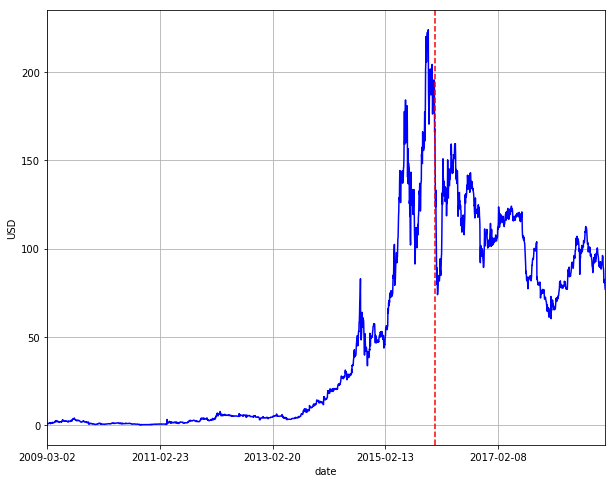

In [34]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = X_all.loc['NHTC'].plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.axvline(x=X_all.loc['NHTC'].index.get_loc('2015-12-31'), color="red", linestyle='--')

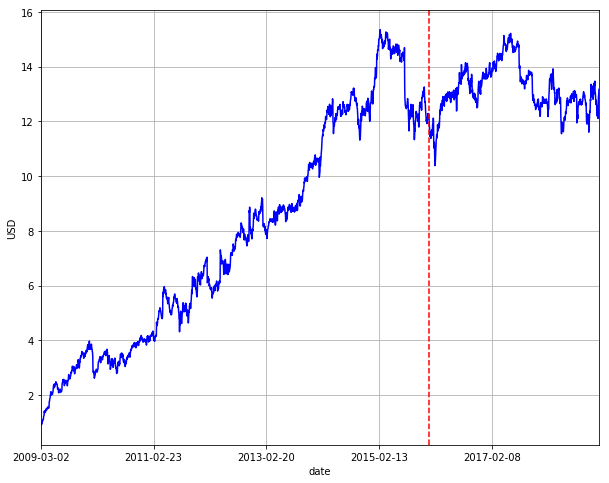

In [35]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = X_all.loc['NEU'].plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.axvline(x=X_all.loc['NHTC'].index.get_loc('2015-12-31'), color="red", linestyle='--')

In [33]:
X_all.loc['NHTC'].index.get_loc('2015-12-31')

1722

In [46]:
X = np.array([[1, 7], [1, 2.5], [1, 0.67], [1, 0.5], [1, 0.33], [1, 4], [1, 3], [1, -1]])
print(X.shape)
y = np.array([1, 0, 0, 0, 0, 1, 1, 0])
print(y.shape)

(8, 2)
(8,)


In [47]:
model = linear_model.LogisticRegression()
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
predicts = model.predict(X)

In [49]:
predicts

array([1, 0, 0, 0, 0, 1, 1, 0])

In [2]:
df = pd.DataFrame([[np.NaN,np.NaN, 1, 7], [np.NaN, 3, 2.5, 5], [1, 0.67, 3], [np.NaN, 1, 0.5, 0.2]])
print(df)

print(df.apply(first_valid_idx, axis=1))

     0     1    2    3
0  NaN   NaN  1.0  7.0
1  NaN  3.00  2.5  5.0
2  1.0  0.67  3.0  NaN
3  NaN  1.00  0.5  0.2
0    1.0
1    3.0
2    1.0
3    1.0
dtype: float64


In [ ]:
df